# Prototyping with Hugging Face

Much of my career in AI was spent in the sales / customer support space. My first startup back in 2015 was focused in these areas and was bought out by a larger customer support company. Because of this, I wanted to do a customer support example!

Our goals will be to:

1. Attempt to re-construct the conversation labels using embedding and clustering models
2. Prompt LLama-2-7b to provide basic feedback to responses to queries
3. Start a mini analysis on agent response scores over time

All using only open-source models from Hugging Face

In [ ]:
HF_KEY = 'hsdfsddsfgdsf'  # replace with your own token: huggingface.co/settings/tokens

In [1]:
from datasets import load_dataset

# https://huggingface.co/datasets/urvog/llama2_transcripts_healthcare_callcenter
callcenter_dataset = load_dataset("urvog/llama2_transcripts_healthcare_callcenter")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /Users/sinanozdemir/.cache/huggingface/datasets/urvog___parquet/urvog--llama2_transcripts_healthcare_callcenter-c2100d673b5aab4c/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
callcenter_dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1000
    })
})

In [6]:
callcenter_dataset['train'][0]

{'text': "<s>[INST] Classify the following call transcript:\n\nAgent 3: Thank you for calling HealthHarbor, my name is Agent 3. How can I assist you today?\n\nCustomer: Hi Agent 3, my name is Emma Johnson. I've been experiencing some symptoms lately and I wanted to seek medical advice or get a symptom assessment.\n\nAgent 3: I'm sorry to hear that, Emma. I'll do my best to help you. Can you please describe the symptoms you've been experiencing?\n\nCustomer: Sure. I've been having a persistent headache for the past few days, and it's been accompanied by dizziness and occasional nausea. I'm not sure what could be causing it.\n\nAgent 3: I understand your concern, Emma. Headaches can have various causes. Have you experienced any recent changes in your lifestyle or any other symptoms besides the headache, dizziness, and nausea?\n\nCustomer: No major lifestyle changes, but I have noticed that my vision seems a bit blurry at times. And I've been feeling more fatigued than usual.\n\nAgent 3: 

# Let's turn our data into a Pandas DataFrame

In [22]:
import pandas as pd

callcenter_df = pd.DataFrame(callcenter_dataset['train'])

def parse_transcript(convo):
    turns = convo.split('\n\n')[1:]
    turns = [[t.split(': ')[0], ': '.join(t.split(': ')[1:])] for t in turns]
    turns[-1][-1] = turns[-1][-1].split('[/INST]')[0].strip()
    return turns

callcenter_df['convo'] = callcenter_df['text'].apply(parse_transcript)

callcenter_df['label'] = callcenter_df['text'].apply(lambda x: x.split('[/INST]')[-1].split('</s>')[0].strip())

callcenter_df.head()

,text,convo,label
0,<s>[INST] Classify the following call transcri...,"[[Agent 3, Thank you for calling HealthHarbor,...",Medical Advice or Symptom Assessment
1,<s>[INST] Classify the following call transcri...,"[[Agent 2, Thank you for calling HealthHarbor,...",General Inquiries
2,<s>[INST] Classify the following call transcri...,"[[Agent 4, Thank you for calling HealthHarbor,...",Lab and Test Results
3,<s>[INST] Classify the following call transcri...,"[[Agent 1, Thank you for calling HealthHarbor,...",Follow-up Calls and Care Management
4,<s>[INST] Classify the following call transcri...,"[[[Phone ringing], ], [Agent 3, Thank you for ...",Medication Refills and Prescription Inquiries


<Axes: title={'center': 'Distribution of actual conversation labels'}, xlabel='label'>

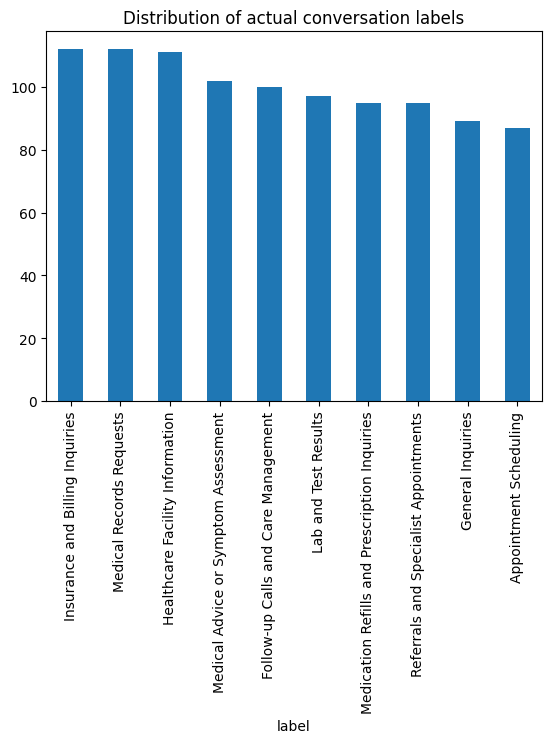

In [355]:
callcenter_df['label'].value_counts().plot.bar(
    title='Distribution of actual conversation labels'
)

# Model 1: embed text 

Using https://huggingface.co/sentence-transformers/all-mpnet-base-v2

In [31]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings = model.encode(callcenter_df['text'])

In [32]:
embeddings.shape

(1000, 768)

In [33]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Model 2 (technically not HF :) )

Cluster analysis on the embeddings

In [358]:
# Variables to store results
sse = []  # Sum of squared distances
silhouette_avg = []

# Range of number of clusters to try
range_n_clusters = range(2, 21)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto').fit(embeddings)
    sse.append(kmeans.inertia_)

    # Calculate silhouette score
    labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(embeddings, labels))


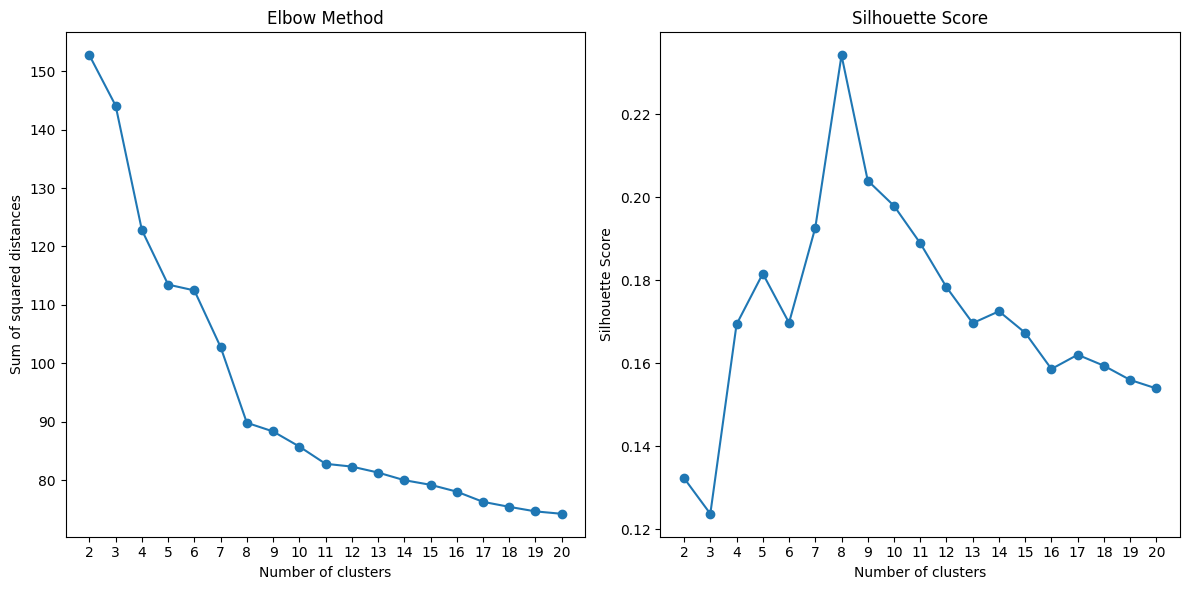

In [359]:
# Plotting the Elbow Method graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.xticks(range_n_clusters)  # Set x-axis ticks to integer values

# Plotting the Silhouette Score graph
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)  # Set x-axis ticks to integer values

plt.tight_layout()
plt.show()

In [360]:
n_clusters = 8  # Adjust based on your data but our elbow method and silhouette score

In [377]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto').fit(embeddings)
labels = kmeans.labels_

# Optimize for Tight Clusters (Optional)
# Calculate silhouette score and adjust 'n_clusters' if necessary
silhouette_avg = silhouette_score(embeddings, labels)
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.2039768397808075


In [378]:
# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

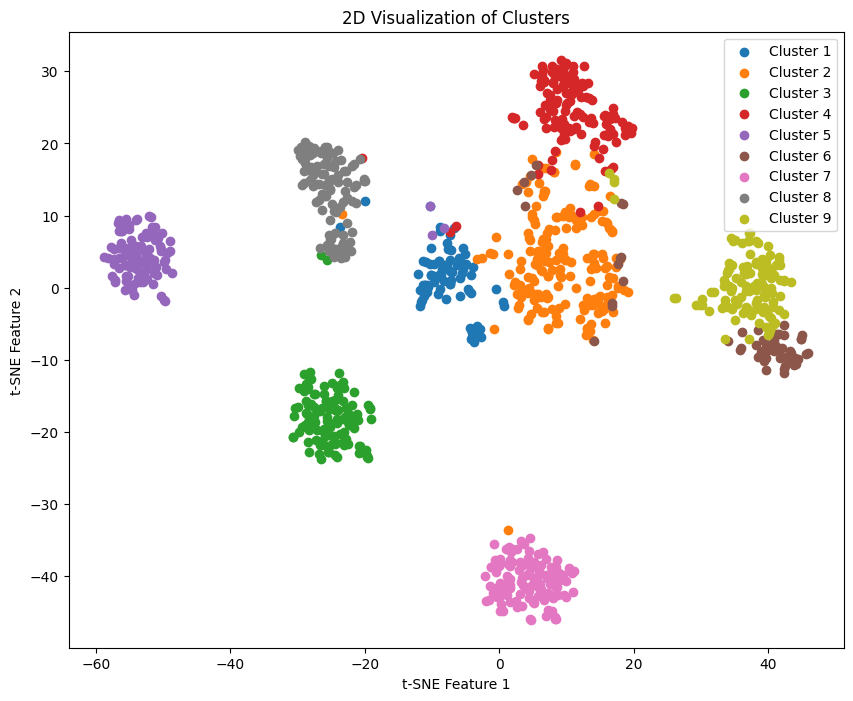

In [379]:
# Plot Clusters
plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    plt.scatter(embeddings_2d[labels == i, 0], embeddings_2d[labels == i, 1], label=f'Cluster {i+1}')
plt.legend()
plt.title('2D Visualization of Clusters')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()

# For top keywords: This requires additional context on how your embeddings were generated
# If embeddings are from text data, you might need to look at the most representative texts of each cluster


<Axes: title={'center': 'Distribution of clusters'}, xlabel='cluster'>

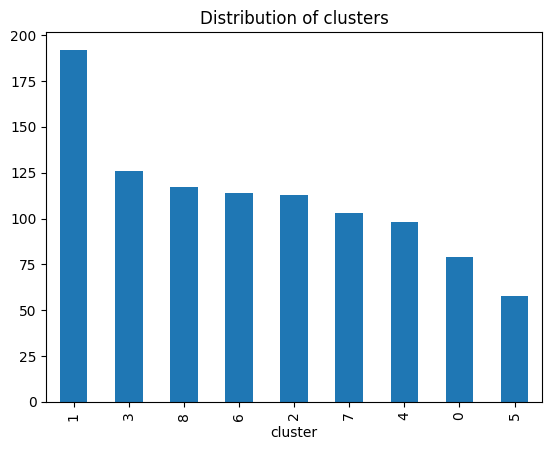

In [380]:
callcenter_df['cluster'] = labels

callcenter_df['cluster'].value_counts().plot.bar(
    title='Distribution of clusters'
)

# Try again with model 3

A model specifically fine-tuned to summarize conversations: https://huggingface.co/kabita-choudhary/finetuned-bart-for-conversation-summary

In [366]:
# Use a pipeline as a high-level helper
from transformers import pipeline

# https://huggingface.co/kabita-choudhary/finetuned-bart-for-conversation-summary
pipe = pipeline("summarization", model="kabita-choudhary/finetuned-bart-for-conversation-summary")

In [54]:
pipe(callcenter_df.iloc[0]['text'])

[{'summary_text': "A customer has been having a headache for the past few days. Agent 3 advises her to consult with a doctor before making a doctor's appointment. She also suggests applying a cold or warm compress to the forehead to relieve the headache and drinking water and getting enough rest. "}]

In [60]:
pipeline_kwargs = {
    'truncation':True,
    'max_length':1024,
    'return_tensors':'pt',
    'batch_size': 8
}

callcenter_df['summary'] = pipe(
    callcenter_df['text'].tolist(), 
    **pipeline_kwargs
)

Your max_length is set to 1024, but your input_length is only 862. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=431)
Your max_length is set to 1024, but your input_length is only 878. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=439)
Your max_length is set to 1024, but your input_length is only 1007. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=503)
Your max_length is set to 1024, but your input_length is only 818. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_len

In [65]:
callcenter_df['summary'] = callcenter_df['summary'].apply(lambda x: pipe.tokenizer.decode(x['summary_token_ids'], skip_special_tokens=True))

In [66]:
callcenter_df.head()

,text,convo,label,cluster,summary
0,<s>[INST] Classify the following call transcri...,"[[Agent 3, Thank you for calling HealthHarbor,...",Medical Advice or Symptom Assessment,3,A customer has been having a headache for the ...
1,<s>[INST] Classify the following call transcri...,"[[Agent 2, Thank you for calling HealthHarbor,...",General Inquiries,5,HealthHarbor is a comprehensive healthcare fac...
2,<s>[INST] Classify the following call transcri...,"[[Agent 4, Thank you for calling HealthHarbor,...",Lab and Test Results,7,Customer has been waiting for lab and test res...
3,<s>[INST] Classify the following call transcri...,"[[Agent 1, Thank you for calling HealthHarbor,...",Follow-up Calls and Care Management,0,Customer was admitted to HealthHarbor last wee...
4,<s>[INST] Classify the following call transcri...,"[[[Phone ringing], ], [Agent 3, Thank you for ...",Medication Refills and Prescription Inquiries,4,"Customer has a prescription for Amlodipine, a ..."


In [67]:
summary_embeddings = model.encode(callcenter_df['summary'])

# Cluster Analysis for the summaries

In [368]:
# Variables to store results
sse = []  # Sum of squared distances
silhouette_avg = []

# Range of number of clusters to try
range_n_clusters = range(2, 21)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto').fit(summary_embeddings)
    sse.append(kmeans.inertia_)

    # Calculate silhouette score
    labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(embeddings, labels))


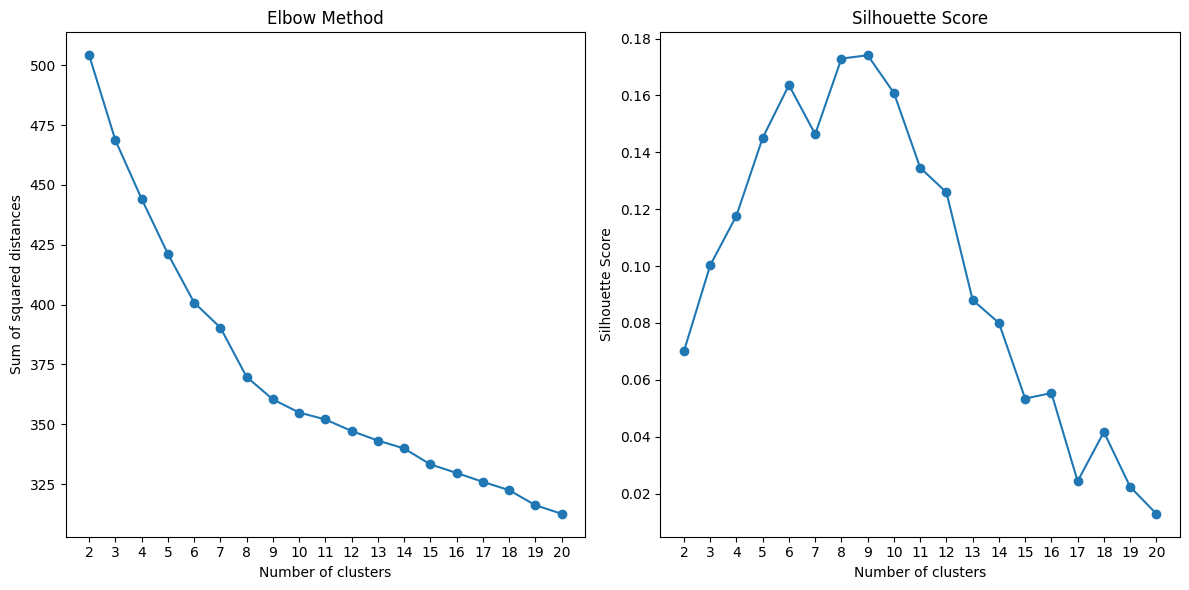

In [370]:
# Plotting the Elbow Method graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.xticks(range_n_clusters)  # Set x-axis ticks to integer values

# Plotting the Silhouette Score graph
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)  # Set x-axis ticks to integer values

plt.tight_layout()
plt.show()

In [382]:
n_clusters = 9  # Adjust based on your data

In [371]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto').fit(summary_embeddings)
labels = kmeans.labels_

# Step 2: Optimize for Tight Clusters (Optional)
# Calculate silhouette score and adjust 'n_clusters' if necessary
silhouette_avg = silhouette_score(embeddings, labels)
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.17413169145584106


In [372]:
# Step 3: Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
summary_embeddings_2d = tsne.fit_transform(summary_embeddings)


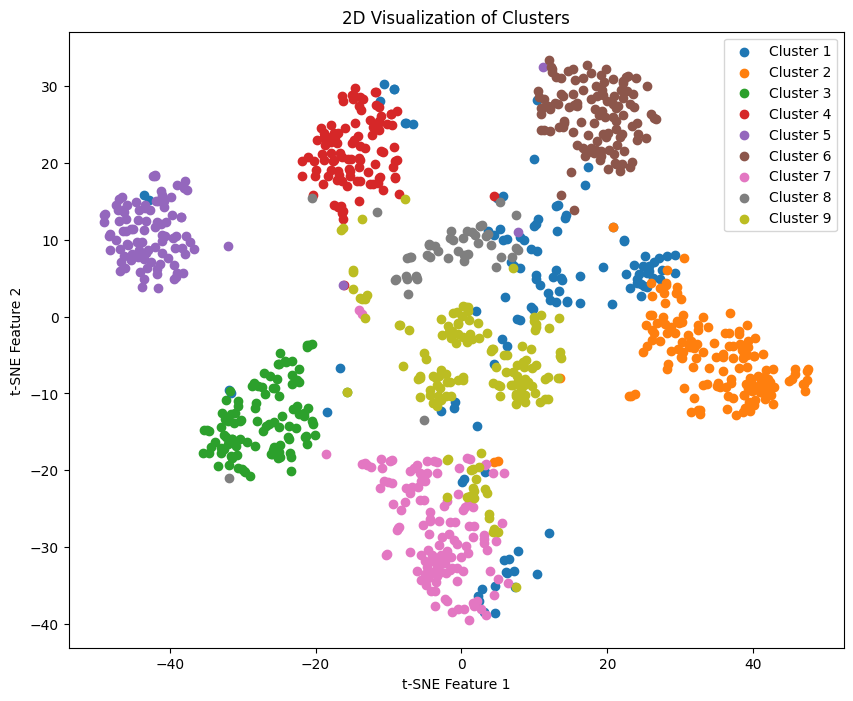

In [373]:
# Step 4: Plot Clusters
plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    plt.scatter(summary_embeddings_2d[labels == i, 0], summary_embeddings_2d[labels == i, 1], label=f'Cluster {i+1}')
plt.legend()
plt.title('2D Visualization of Clusters')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()

# For top keywords: This requires additional context on how your embeddings were generated
# If embeddings are from text data, you might need to look at the most representative texts of each cluster


<Axes: title={'center': 'Distribution of clusters'}, xlabel='conversation_cluster'>

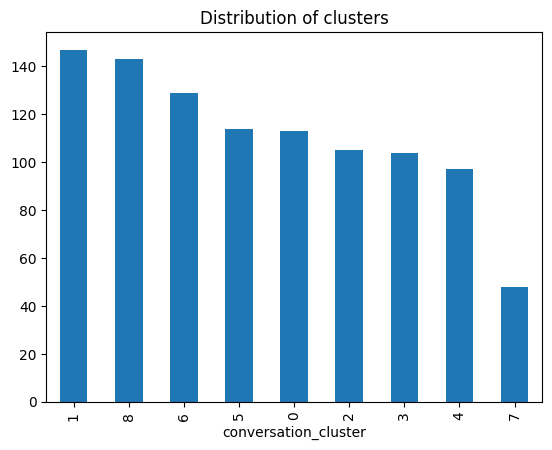

In [376]:
callcenter_df['conversation_cluster'] = labels

callcenter_df['conversation_cluster'].value_counts().plot.bar(
    title='Distribution of clusters'
)

# Using Model 4 (LLama 2) va the Inference API

We will as llama to summarize several conversation summaries into a single label for the entire cluster

https://ui.endpoints.huggingface.co


In [381]:
import requests

API_URL = "https://sa0b44ky03zvbtds.us-east-1.aws.endpoints.huggingface.cloud"
headers = {
	"Accept" : "application/json",
	"Authorization": f"Bearer {HF_KEY}",
	"Content-Type": "application/json" 
}

def query_llama_2(payload):
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()


# I will use the clusters with the higher silhouette score

In [ ]:
convos = []

In [449]:
CLUSTER_TO_USE = 'cluster'

In [483]:
shorter_convos = callcenter_df[callcenter_df['text'].str.len() < 3000]

In [488]:
# cluster_summaries = []

for label in sorted(set(labels))[len(cluster_summaries):]:
    print(label)
    convos = shorter_convos[shorter_convos[CLUSTER_TO_USE] == label]['summary'].sample(15).tolist()
    
    DELIM = '\n---\n'
    output = query_llama_2({
    	"inputs": f"<s>[INST] <<SYS>> Summarize these into a single description of up to 10 words / one sentence. Make the summaries very short. For example: \"Inquiring about phone records\" or \"Called to order a burger\" <</SYS>> {DELIM.join(convos)}\n\none sentence only:[/INST]",
    	"parameters": {
    		"max_new_tokens": 256
    	}
    })
    summary = output[0]['generated_text'].strip()
    print(summary)
    cluster_summaries.append(summary)
    print('----')

8
Customer seeks medical services at HealthHarbor, including cardiology, orthopedics, emergency care, and general medicine, with a focus on quality care and modern facilities.
----


# Model 5: Using T5 to shorten these summaries up

This is actually a model I fine-tune in my most recent book and for our Reinforcement Learning sessions on this platform!

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

summarize_pipe = pipeline("text2text-generation", model="profoz/t5-aligned-summaries")

In [489]:
['summarize: ' + c for c in cluster_summaries]

['summarize: A patient had a procedure at HealthHarbor, experienced complications, or was dissatisfied with their care, and an agent assisted them by scheduling a follow-up appointment, providing post-operative care instructions, or addressing their concerns.',
 'summarize: A customer seeks appointments with specialists, including a dermatologist, orthopedic surgeon, gastroenterologist, neurologist, and others, with Agent 3 assisting with scheduling and confirming appointments.',
 'summarize: Customers need to request medical records from HealthHarbor for various reasons, including seeing a specialist, transferring records to a new doctor, and obtaining operative reports and lab test results.',
 'summarize: Customer seeks medical advice for various symptoms such as headaches, dizziness, fatigue, nausea, and fever, and agents provide advice on seeking immediate medical attention, keeping a symptom diary, and managing stress, while some agents also offer general advice and recommend heal

In [490]:
[_['generated_text'] for _ in summarize_pipe(['summarize: ' + c for c in cluster_summaries], max_new_tokens=36)]

['A patient who had a procedure at HealthHarbor was referred to a health professional.',
 'A customer is referred to an agent for a specific appointment.',
 'HealthHarbor is a health service that provides medical records to customers in the United States.',
 'A customer is referred to as a healthcare professional',
 'Customers can contact agents for medication refills and prescriptions, including blood pressure medication, allergy medication, and new medication side effects, with agents sending requests to healthcare providers, updating records',
 'HealthHarbor is a comprehensive healthcare facility offering various medical services, including emergency care, surgery, maternity care, pediatrics, cardiology, radiology, oncology',
 'Customer has questions or issues regarding their insurance and billing, including incorrect charges, missing pre-authorization, and overcharging, and agent will help resolve the issue by contacting',
 'HealthHarbor is a company that has been supplying a custo

In [491]:
cluster_summaries = [_['generated_text'] for _ in summarize_pipe(['summarize: ' + c for c in cluster_summaries], max_new_tokens=36)]

In [492]:
callcenter_df['cluster_label'] = callcenter_df[CLUSTER_TO_USE].map(lambda x: cluster_summaries[x])

<Axes: xlabel='cluster_label'>

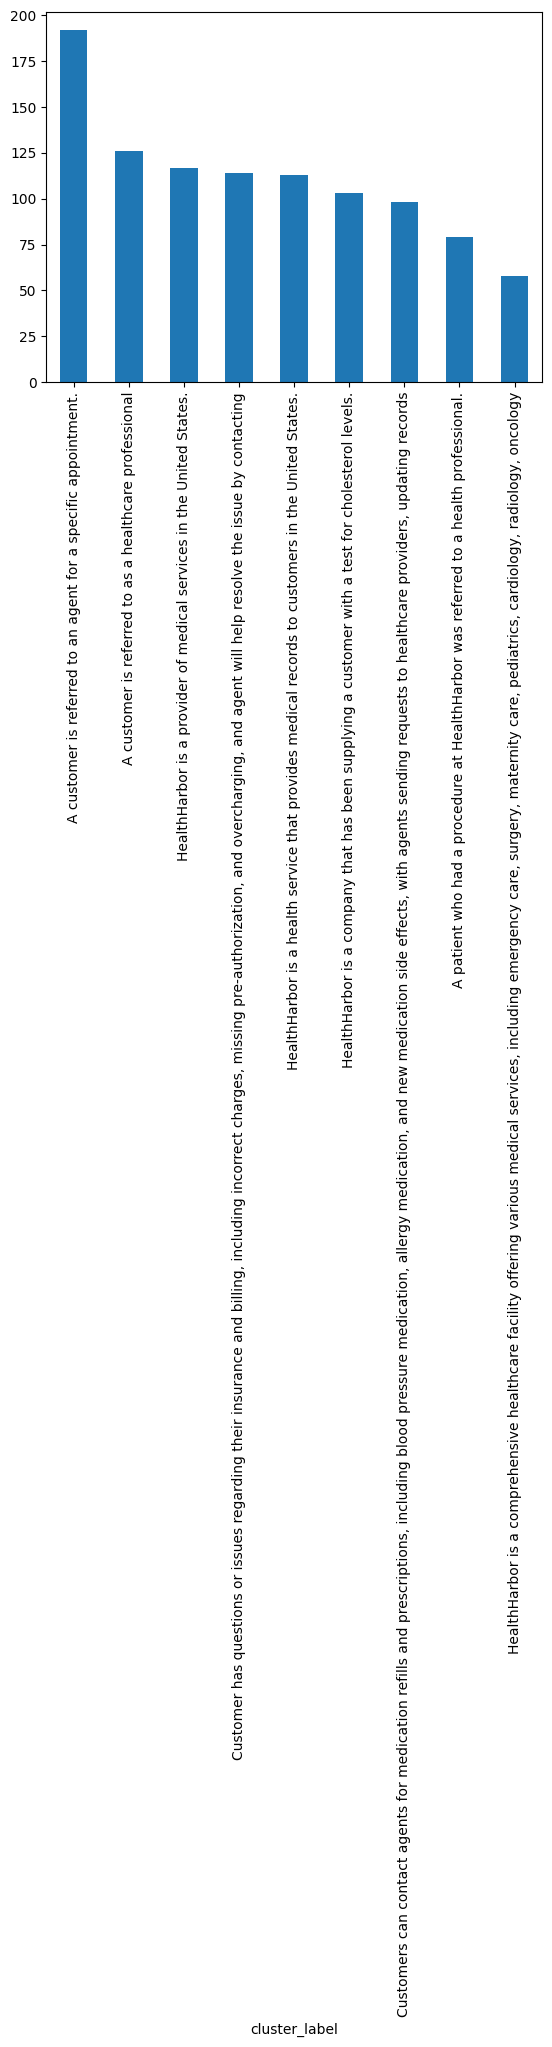

In [493]:
callcenter_df['cluster_label'].value_counts().plot.bar()

<Axes: xlabel='label'>

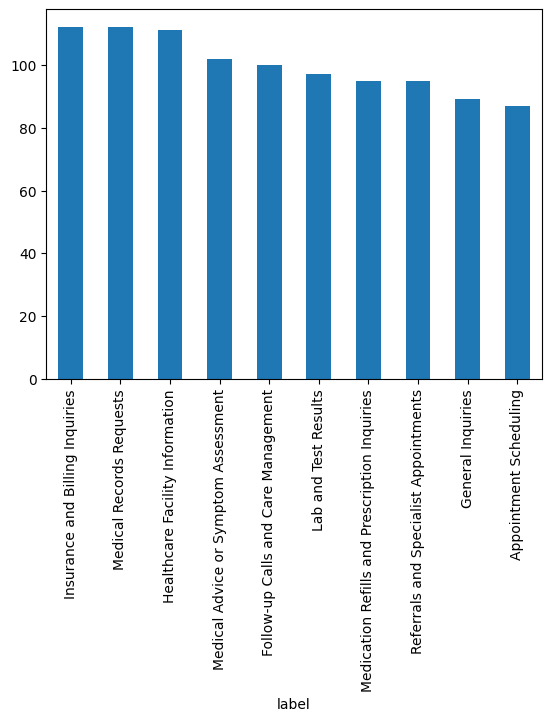

In [494]:
callcenter_df['label'].value_counts().plot.bar()

# Compare our clusters with the labeled results

In [495]:
from itertools import product

# Extract unique values from 'label' and 'cluster_label' columns
unique_labels = callcenter_df['label'].unique()
unique_cluster_labels = callcenter_df['cluster_label'].unique()

# Generate all unique combinations (pairings) of these values
label_combinations = list(product(unique_labels, unique_cluster_labels))

# Display the first few combinations for review
label_combinations[:5]


[('Medical Advice or Symptom Assessment',
  'A customer is referred to as a healthcare professional'),
 ('Medical Advice or Symptom Assessment',
  'HealthHarbor is a comprehensive healthcare facility offering various medical services, including emergency care, surgery, maternity care, pediatrics, cardiology, radiology, oncology'),
 ('Medical Advice or Symptom Assessment',
  'HealthHarbor is a company that has been supplying a customer with a test for cholesterol levels.'),
 ('Medical Advice or Symptom Assessment',
  'A patient who had a procedure at HealthHarbor was referred to a health professional.'),
 ('Medical Advice or Symptom Assessment',
  'Customers can contact agents for medication refills and prescriptions, including blood pressure medication, allergy medication, and new medication side effects, with agents sending requests to healthcare providers, updating records')]

In [511]:
label_to_set('sdg')

{'sdg'}

In [514]:
pair = label_combinations[0]
pair

('Medical Advice or Symptom Assessment',
 'A customer is referred to as a healthcare professional')

(Index([ 15,  27,  32,  34,  38,  67,  73,  83,  86, 112, 117, 119, 124, 131,
        155, 159, 192, 220, 249, 255, 279, 298, 316, 322, 333, 345, 349, 353,
        379, 402, 412, 430, 431, 477, 479, 507, 514, 519, 520, 522, 535, 544,
        550, 554, 563, 570, 571, 588, 590, 594, 602, 609, 613, 614, 615, 616,
        621, 625, 628, 634, 637, 638, 663, 676, 683, 687, 700, 712, 735, 777,
        786, 792, 795, 839, 845, 851, 863, 882, 886, 903, 912, 924, 927, 947,
        952, 991, 996],
       dtype='int64'),
 Index([ 15,  27,  32,  34,  35,  37,  38,  67,  73,  74,
        ...
        951, 952, 963, 971, 976, 978, 982, 988, 991, 996],
       dtype='int64', length=192))

In [520]:
for pair in label_combinations:
    if callcenter_df[(callcenter_df['label'] == pair[0]) & (callcenter_df['cluster_label'] == pair[1])].shape[0] > 0:
        print(pair, callcenter_df[(callcenter_df['label'] == pair[0]) & (callcenter_df['cluster_label'] == pair[1])].shape[0])

('Medical Advice or Symptom Assessment', 'A customer is referred to as a healthcare professional') 100
('Medical Advice or Symptom Assessment', 'A customer is referred to an agent for a specific appointment.') 2
('General Inquiries', 'A customer is referred to as a healthcare professional') 14
('General Inquiries', 'HealthHarbor is a comprehensive healthcare facility offering various medical services, including emergency care, surgery, maternity care, pediatrics, cardiology, radiology, oncology') 36
('General Inquiries', 'A patient who had a procedure at HealthHarbor was referred to a health professional.') 2
('General Inquiries', 'HealthHarbor is a provider of medical services in the United States.') 27
('General Inquiries', 'A customer is referred to an agent for a specific appointment.') 10
('Lab and Test Results', 'HealthHarbor is a company that has been supplying a customer with a test for cholesterol levels.') 94
('Lab and Test Results', 'HealthHarbor is a health service that pro

0.4307692307692308

In [527]:
from sklearn.metrics import jaccard_score
import numpy as np

# Function to convert labels into sets of words
def label_to_set(label):
    return set(label.lower().replace('-', ' ').split())

# Function to calculate Jaccard similarity index for two labels
def calculate_jaccard_similarity(set1, set2):
    set1, set2 = set(set1), set(set2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# Calculate Jaccard similarity for each combination
similarity_results = [(pair[0], pair[1], calculate_jaccard_similarity(
    callcenter_df[(callcenter_df['label'] == pair[0])].index, callcenter_df[(callcenter_df['cluster_label'] == pair[1])].index
)) for pair in label_combinations]

# Convert to DataFrame for better visualization and sort by similarity
similarity_df = pd.DataFrame(similarity_results, columns=['Label', 'Cluster Label', 'Jaccard Similarity'])
similarity_df_sorted = similarity_df.sort_values(by='Jaccard Similarity', ascending=False)

# Display the top combinations with the highest similarity
similarity_df_sorted.head(10)


,Label,Cluster Label,Jaccard Similarity
60,Insurance and Billing Inquiries,Customer has questions or issues regarding the...,0.982456
79,Medical Records Requests,HealthHarbor is a health service that provides...,0.973684
40,Medication Refills and Prescription Inquiries,Customers can contact agents for medication re...,0.969388
20,Lab and Test Results,HealthHarbor is a company that has been supply...,0.886792
0,Medical Advice or Symptom Assessment,A customer is referred to as a healthcare prof...,0.781250
30,Follow-up Calls and Care Management,A patient who had a procedure at HealthHarbor ...,0.721154
50,Healthcare Facility Information,HealthHarbor is a provider of medical services...,0.652174
89,Appointment Scheduling,A customer is referred to an agent for a speci...,0.430769
71,Referrals and Specialist Appointments,A customer is referred to an agent for a speci...,0.393204
10,General Inquiries,HealthHarbor is a comprehensive healthcare fac...,0.324324


In [534]:
similarity_df_sorted.groupby('Label')['Jaccard Similarity'].max().sort_values()
# We did find some top issues (insurance, billing, refills, test results, etc)
#  with only a bit of free open source work :)

Label
General Inquiries                                0.324324
Referrals and Specialist Appointments            0.393204
Appointment Scheduling                           0.430769
Healthcare Facility Information                  0.652174
Follow-up Calls and Care Management              0.721154
Medical Advice or Symptom Assessment             0.781250
Lab and Test Results                             0.886792
Medication Refills and Prescription Inquiries    0.969388
Medical Records Requests                         0.973684
Insurance and Billing Inquiries                  0.982456
Name: Jaccard Similarity, dtype: float64

In [540]:
# Investigating a highly ranked label...

similarity_df_sorted[similarity_df_sorted['Label'] == 'Insurance and Billing Inquiries'].head(3)

,Label,Cluster Label,Jaccard Similarity
60,Insurance and Billing Inquiries,Customer has questions or issues regarding the...,0.982456
61,Insurance and Billing Inquiries,HealthHarbor is a health service that provides...,0.000000
62,Insurance and Billing Inquiries,A customer is referred to an agent for a speci...,0.000000


In [538]:
# Investigating a low ranked label...

similarity_df_sorted[similarity_df_sorted['Label'] == 'Referrals and Specialist Appointments'].head(3)

,Label,Cluster Label,Jaccard Similarity
71,Referrals and Specialist Appointments,A customer is referred to an agent for a speci...,0.393204
64,Referrals and Specialist Appointments,HealthHarbor is a comprehensive healthcare fac...,0.069930
63,Referrals and Specialist Appointments,A customer is referred to as a healthcare prof...,0.018433


# use LLama 2 to diagnose individual conversations

In [499]:
SYSTEM_PROMPT = "### Rating Task\nRate the performance of an assistant in response to a user question.\n\nOutput a score from 1 to 10 where a 1 means you strongly do not suggest saying the response because it is inappropriate for example and 10 means you strongly advise for that response and 5 means that the response is just ok.\n\nGive all answers in the json format: \n\nQuery: (example query)\nResponse: (example response)\nJSON: {\"reason\": \"This response is not good because...\", \"score\": Y}"

print(SYSTEM_PROMPT)

### Rating Task
Rate the performance of an assistant in response to a user question.

Output a score from 1 to 10 where a 1 means you strongly do not suggest saying the response because it is inappropriate for example and 10 means you strongly advise for that response and 5 means that the response is just ok.

Give all answers in the json format: 

Query: (example query)
Response: (example response)
JSON: {"reason": "This response is not good because...", "score": Y}


In [301]:
import re, json

def get_llama_rubric(query, answer):
    user_prompt = f"### User Question\n{query}\n\n### The Start of Assistant's Answer\n{answer}\n### The End of Assistant\'s Answer\n\n### Now give your answer as a valid JSON response. Starting the correct format now:\n\nQuery: {query}\nResponse: {answer}\nJSON:"
    prompt = f"""<s>[INST] <<SYS>> {SYSTEM_PROMPT} <</SYS>> """+user_prompt+""" [/INST]"""
    
    def query(payload):
    	response = requests.post(API_URL, headers=headers, json=payload)
    	return response.json()
    	
    try:
        output = query({
        	"inputs": prompt,
            "parameters": {"max_new_tokens": 512, "temperature": 0.01},
        })[0]['generated_text'].strip()
    except Exception as e:
        return {'score': -1}
    # Extract the JSON string
        
    # Regular expression pattern
    pattern = r"({.*?})"
    
    # Find the JSON string
    match = re.search(pattern, output.replace('\n', ' '), re.DOTALL)
    if match:
        json_string = match.group(1)
        # print(json_string)
    
        # Convert the string to a JSON object
        json_data = json.loads(json_string)
        return json_data
    else:
        print('ERROR', output)
        None

In [303]:
get_llama_rubric(
    'How do you greet someone',
    'Try telling them "Hello!"'
)

{'reason': "This response is a good start, but it's not the most creative or personalized greeting. A simple 'hello' may not be enough to make a good impression. Consider adding a personalized message or a small compliment to make the greeting more meaningful.",
 'score': 5}

In [304]:
get_llama_rubric(
    'How do you greet someone',
    'Try telling them good bye I think'
)

{'reason': "This response is not helpful or appropriate for greeting someone. It is not a common or polite greeting, and it may come across as insensitive or dismissive. A better response would be something like 'Hello, how are you?' or 'Hi, it's nice to meet you.'",
 'score': 3}

In [302]:
get_llama_rubric(
    "Hi Agent 3, my name is Emma Johnson. I've been experiencing some symptoms lately and I wanted to seek medical advice or get a symptom assessment.",
    "I'm sorry to hear that, Emma. I'll do my best to help you. Can you please describe the symptoms you've been experiencing?"
)

{'reason': "This response is good because it shows empathy and a willingness to help Emma. It also asks for more information to provide a more accurate assessment of Emma's symptoms.",
 'score': 8}

In [434]:
convo = callcenter_df['convo'].iloc[0]
convo[:3]

[['Agent 3',
  'Thank you for calling HealthHarbor, my name is Agent 3. How can I assist you today?'],
 ['Customer',
  "Hi Agent 3, my name is Emma Johnson. I've been experiencing some symptoms lately and I wanted to seek medical advice or get a symptom assessment."],
 ['Agent 3',
  "I'm sorry to hear that, Emma. I'll do my best to help you. Can you please describe the symptoms you've been experiencing?"]]

In [343]:
conversations = callcenter_df['convo'].iloc[:5]

# Iterate through the list to form human-assistant pairs
human_assistant_pairs = []
for convo_idx, convo in enumerate(conversations):
    for i, utterance in enumerate(convo):
        if convo[i][0] == 'Customer' and 'Agent' in convo[i + 1][0]:
            pair = (convo[i][1], convo[i + 1][1], convo_idx)
            human_assistant_pairs.append(pair)

scores = []
for pair in human_assistant_pairs:
    llama_response = get_llama_rubric(pair[0], pair[1])
    scores.append(llama_response)
    print("Customer:", pair[0])
    print("Agent:", pair[1])
    print("---")
    print(llama_response)
    print("---")
    print("---")

Customer: Hi Agent 3, my name is Emma Johnson. I've been experiencing some symptoms lately and I wanted to seek medical advice or get a symptom assessment.
Agent: I'm sorry to hear that, Emma. I'll do my best to help you. Can you please describe the symptoms you've been experiencing?
---
{'reason': "This response is good because it shows empathy and a willingness to help Emma. It also asks for more information to provide a more accurate assessment of Emma's symptoms.", 'score': 8}
---
---
Customer: Sure. I've been having a persistent headache for the past few days, and it's been accompanied by dizziness and occasional nausea. I'm not sure what could be causing it.
Agent: I understand your concern, Emma. Headaches can have various causes. Have you experienced any recent changes in your lifestyle or any other symptoms besides the headache, dizziness, and nausea?
---
{'reason': 'This response is a good start, but there are some areas that could be improved. Firstly, the assistant could ha

In [353]:
convo_df = pd.DataFrame({
    'reason': [result.get('reason') for result in scores],
    'score': [result.get('score') for result in scores],
    'query': [h[0] for h in human_assistant_pairs],
    'response': [h[1] for h in human_assistant_pairs],
    'conversation_id': [h[2] for h in human_assistant_pairs]
})
convo_df.head()

,reason,score,query,response,conversation_id
0,This response is good because it shows empathy...,8.0,"Hi Agent 3, my name is Emma Johnson. I've been...","I'm sorry to hear that, Emma. I'll do my best ...",0
1,"This response is a good start, but there are s...",6.0,Sure. I've been having a persistent headache f...,"I understand your concern, Emma. Headaches can...",0
2,The response is ok because it acknowledges the...,5.0,"No major lifestyle changes, but I have noticed...","Thank you for sharing that information, Emma. ...",0
3,The response is mostly helpful and provides so...,8.0,I was hoping to get some advice before schedul...,"While I'm not a doctor, I can offer some gener...",0
4,The response is appropriate and helpful. It ad...,10.0,I understand. I'll make sure to schedule an ap...,"You're welcome, Emma. It's always better to be...",0


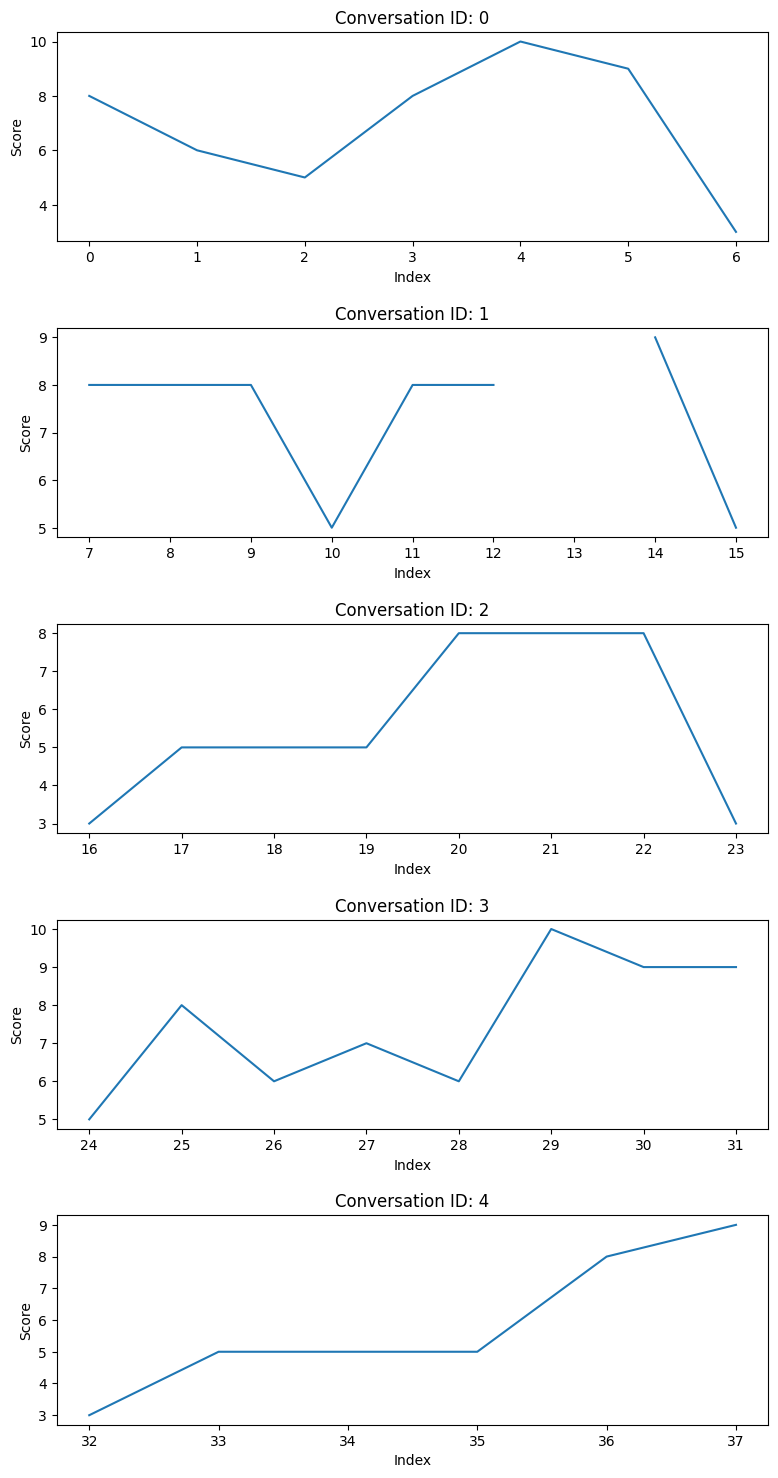

In [352]:
import matplotlib.pyplot as plt

# Get unique conversation IDs
conversation_ids = convo_df['conversation_id'].unique()

# Calculate the number of subplots needed based on the number of unique conversation IDs
num_subplots = len(conversation_ids)

# Create subplots
fig, axs = plt.subplots(num_subplots, 1, figsize=(8, 3*num_subplots))

# Plot each group in a separate subplot
for i, convo_id in enumerate(conversation_ids):
    ax = axs[i] if num_subplots > 1 else axs  # If only one subplot, axs is not a list
    convo_df[convo_df['conversation_id'] == convo_id]['score'].plot(ax=ax, kind='line')
    ax.set_title(f'Conversation ID: {convo_id}')
    ax.set_xlabel('Index')
    ax.set_ylabel('Score')

# Adjust layout
plt.tight_layout(pad=1.5)

# Show the plot
plt.show()
